In [1]:
import geopandas as gpd
import pandas as pd

import folium
from folium.plugins import HeatMap

import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib import colors

In [2]:
property_df = pd.read_parquet("../../data/raw/property_details_w_distances.parquet")
suburbs_gdf = gpd.read_parquet('../../data/curated/suburb_shapefile_w_postcodes.parquet')

property_gdf = gpd.GeoDataFrame(
    property_df, geometry=gpd.points_from_xy(property_df.longitude, property_df.latitude), crs="EPSG:4326"
)

# Reproject both GeoDataFrames to the same CRS (WGS84 is what Folium uses)
suburbs_gdf = suburbs_gdf.to_crs(epsg=4326)
property_gdf = property_gdf.to_crs(epsg=4326)

# Check if everything loaded correctly
property_gdf.head()
suburbs_gdf.head()

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry,postcode
0,lcp-ejVyte1DxXx,locb0dcb52a6b55,2023-06-26,Abbeyard,Gazetted Locality,VIC,"POLYGON ((146.65061 -36.94496, 146.68449 -36.9...",3737
1,lcp386f2bcf9bce,locb9872f35df41,2021-06-24,Abbotsford,Gazetted Locality,VIC,"POLYGON ((144.99137 -37.80959, 144.99254 -37.8...",3067
2,lcprFRP2-cPMfr5,loc8123ed12ea8d,2023-03-21,Aberfeldie,Gazetted Locality,VIC,"POLYGON ((144.88854 -37.75546, 144.88854 -37.7...",3040
3,lcpj3KHi-vakgFj,loc1eb4a229104a,2023-12-10,Aberfeldy,Gazetted Locality,VIC,"POLYGON ((146.35535 -37.69944, 146.35751 -37.6...",3825
4,lcpoO-hq-yZZASg,locb17be87767e1,2023-12-10,Acheron,Gazetted Locality,VIC,"POLYGON ((145.638 -37.28417, 145.64233 -37.279...",3714


In [3]:
# Calculate centroid of the properties to center the map
centroid = property_gdf.geometry.centroid
center_lat = centroid.y.mean()
center_lon = centroid.x.mean()

# Create a base Folium map centered on the mean coordinates
m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Prepare the heatmap data: [latitude, longitude, price]
heat_data = [[row['geometry'].y, row['geometry'].x, row['price']] for index, row in property_gdf.iterrows()]

# Add the heatmap to the folium map
HeatMap(heat_data, radius=10, blur=15, max_zoom=10).add_to(m)

m

/tmp/ipykernel_208462/2743098247.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = property_gdf.geometry.centroid


In [4]:
property_counts = property_df.groupby('postcode').size().reset_index(name='property_count')
suburbs_gdf = suburbs_gdf.merge(property_counts, on='postcode', how='left')

suburbs_gdf['property_count'] = suburbs_gdf['property_count'].fillna(0)
suburbs_gdf['size'] = suburbs_gdf['property_count']

average_price = property_df.groupby('postcode')['price'].mean().reset_index(name='avg_price')
suburbs_gdf = suburbs_gdf.merge(average_price, on='postcode', how='left')

suburbs_gdf['avg_price'] = suburbs_gdf['avg_price'].fillna(0)

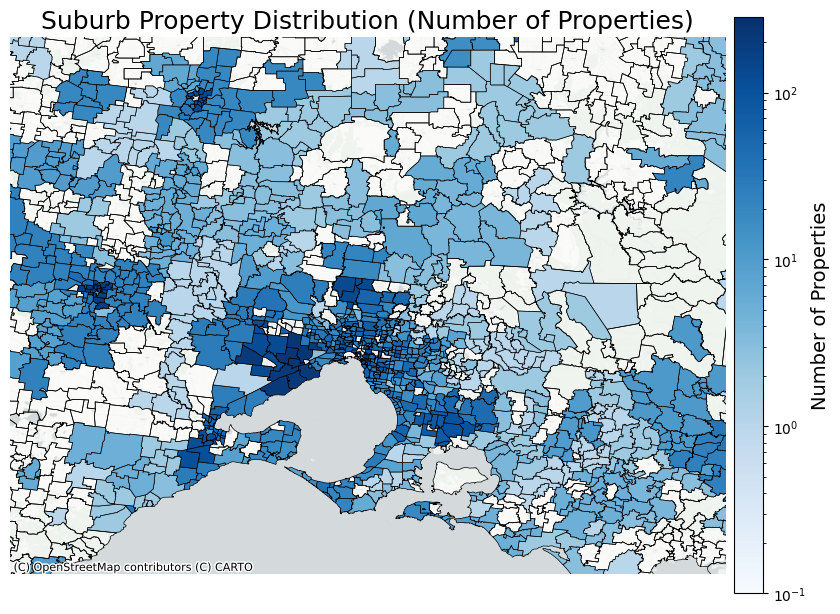

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_xlim([143.5, 146.5])
ax.set_ylim([-38.75, -36.5])

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8)

vmin, vmax = 0.1, suburbs_gdf['size'].max()
cmap = 'Blues'
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

ax = suburbs_gdf.plot(column='size', linewidth=0.5, edgecolor='black', 
                      cmap=cmap, legend=False, ax=ax, norm=norm)


ctx.add_basemap(ax, crs=suburbs_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

ax.set_title('Suburb Property Distribution (Number of Properties)', fontsize=18)

ax.set_axis_off()

patch_col = ax.collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.72, orientation="vertical", pad=0.01)
cb.ax.set_ylabel('Number of Properties', fontsize=14)

plt.show()

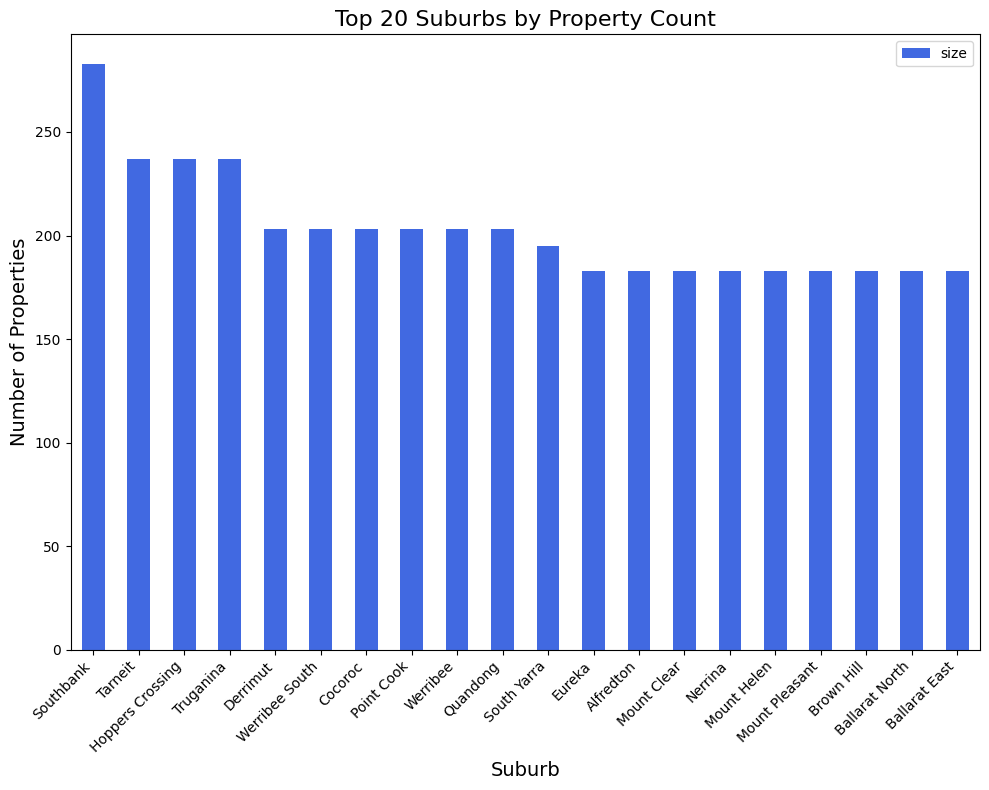

In [6]:
# Sort the suburbs GeoDataFrame by property count ('size') and select top 20 suburbs
top_suburbs = suburbs_gdf[['LOC_NAME', 'size']].sort_values(by='size', ascending=False).head(20)

# Create a bar plot for the top 20 suburbs
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the top 20 suburbs by property count
top_suburbs.plot(kind='bar', x='LOC_NAME', y='size', ax=ax, color='royalblue')

# Set labels and title
ax.set_xlabel('Suburb', fontsize=14)
ax.set_ylabel('Number of Properties', fontsize=14)
ax.set_title('Top 20 Suburbs by Property Count', fontsize=16)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(top_suburbs['LOC_NAME'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

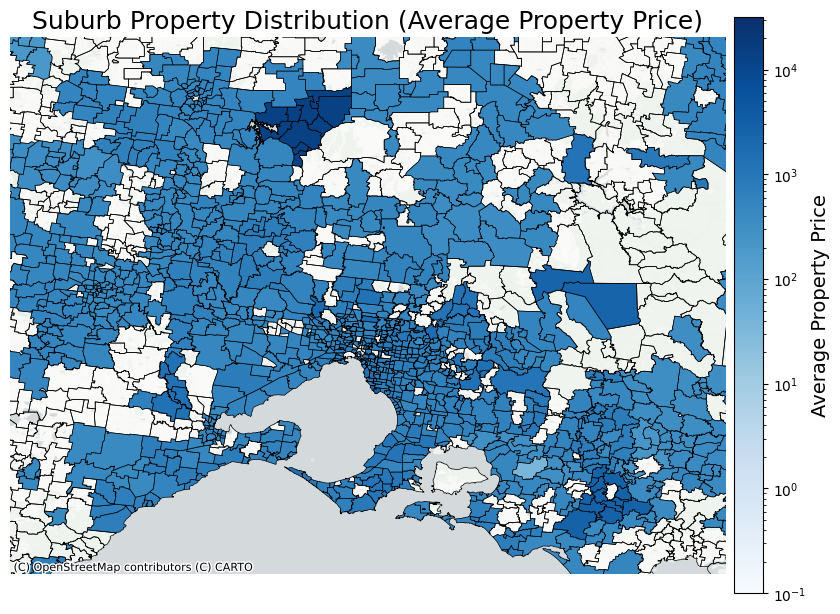

In [10]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 10))

ax.set_xlim([143.5, 146.5])
ax.set_ylim([-38.75, -36.5])

# Adjust the figure layout for better spacing
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8)

# Set minimum and maximum for the color range (without LogNorm)
vmin, vmax = 0.1, suburbs_gdf['avg_price'].max()
cmap = 'Blues'
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Plot the suburbs data, colored by the 'avg_price' column
ax = suburbs_gdf.plot(column='avg_price', linewidth=0.5, edgecolor='black', 
                      cmap=cmap, legend=False, ax=ax, norm=norm)


# Add the basemap again after setting the limits
ctx.add_basemap(ax, crs=suburbs_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron, zoom=12)

# Set the title of the map
ax.set_title('Suburb Property Distribution (Average Property Price)', fontsize=18)

# Remove the axes for a cleaner look
ax.set_axis_off()

# Add a colorbar to show the range of values
patch_col = ax.collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.72, orientation="vertical", pad=0.01)
cb.ax.set_ylabel('Average Property Price', fontsize=14)

# Display the plot
plt.show()

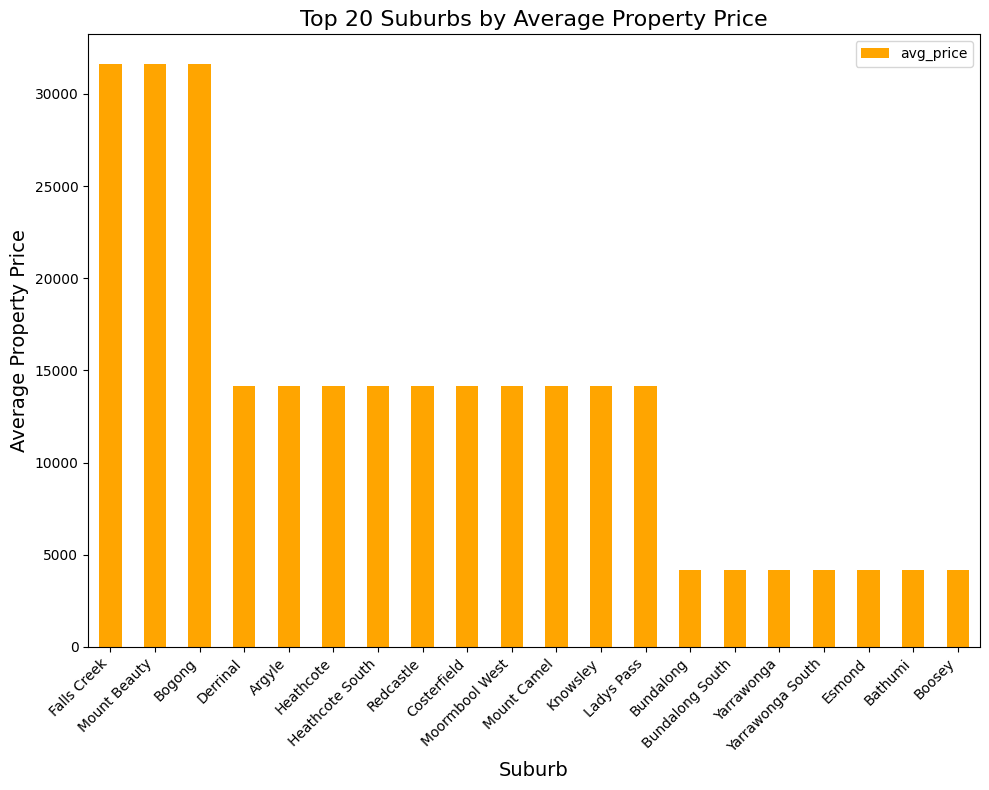

In [9]:
# Sort the suburbs GeoDataFrame by average price and select the top 20 suburbs
top_price_suburbs = suburbs_gdf[['LOC_NAME', 'avg_price']].sort_values(by='avg_price', ascending=False).head(20)

# Create a bar plot for the top 20 suburbs by average price
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the top 20 suburbs by property price
top_price_suburbs.plot(kind='bar', x='LOC_NAME', y='avg_price', ax=ax, color='orange')

# Set labels and title
ax.set_xlabel('Suburb', fontsize=14)
ax.set_ylabel('Average Property Price', fontsize=14)
ax.set_title('Top 20 Suburbs by Average Property Price (>10 Properties)', fontsize=16)

# Rotate the x-axis labels for better readability
ax.set_xticklabels(top_price_suburbs['LOC_NAME'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()
